In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer, weighted_quantile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
import os
import seaborn as sns

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [11]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


## Reference trajectory

In [12]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)

In [13]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)

In [14]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [15]:
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(250, 3, 5)


In [16]:
# def f(beta, ntot, ninf):
#     p = 1 - tf.math.exp(tf.math.log(1 - tf.reshape(beta, (-1, 1)))
#                           * tf.reduce_sum((ninf) / ntot[:, :, tf.newaxis], axis=2))
#     return p
# p = []
# for i in np.linspace(0,1,10):
#     ninf = np.zeros((1,M), dtype = np.float32)
#     ninf[0,0] = i
#     print (f(0.01, np.ones((1,M), dtype = np.float32),ninf))
#     p.append(f(0.01, np.ones((1,M), dtype = np.float32),ninf))


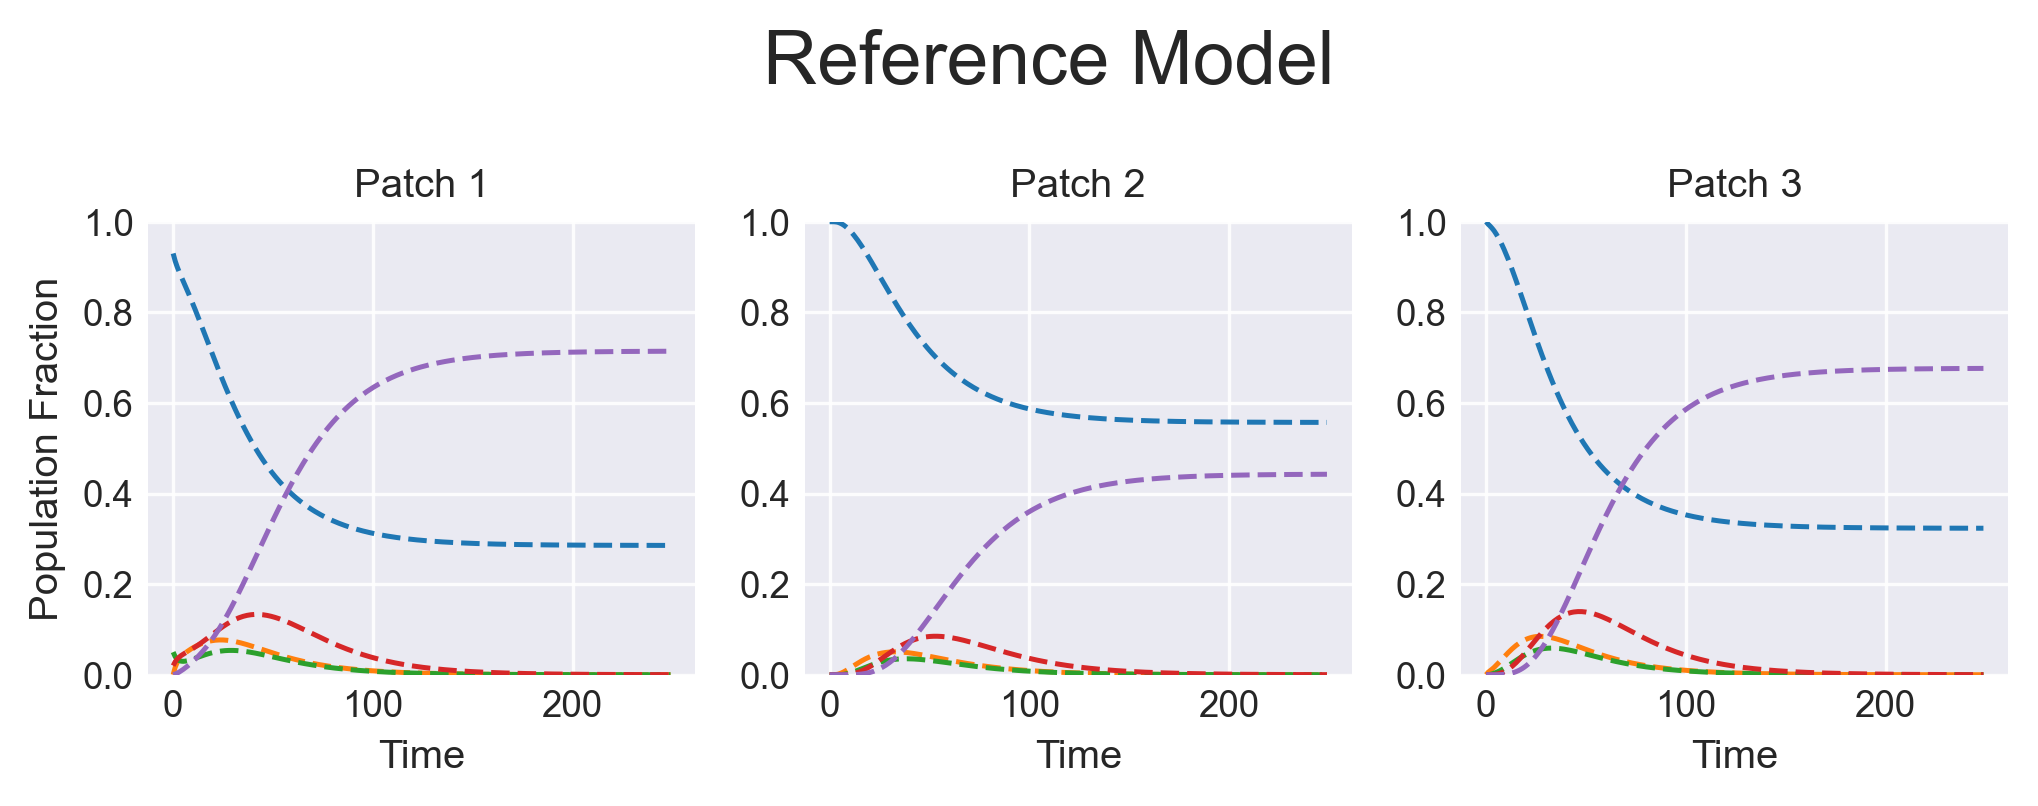

tf.Tensor(
[[9.3000001e-01 0.0000000e+00 5.0000001e-02 2.0000000e-02 0.0000000e+00]
 [9.1351068e-01 1.6489347e-02 4.0000003e-02 2.8571427e-02 1.4285714e-03]
 [9.0063554e-01 2.7008828e-02 3.4355622e-02 3.4530610e-02 3.4693875e-03]
 ...
 [2.8569031e-01 9.8567813e-05 8.5043037e-05 4.6003459e-04 7.1366608e-01]
 [2.8567964e-01 9.5171024e-05 8.2115548e-05 4.4418356e-04 7.1369892e-01]
 [2.8566933e-01 9.1897942e-05 7.9288300e-05 4.2887928e-04 7.1373063e-01]], shape=(230, 5), dtype=float32)
tf.Tensor(
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [5.57283759e-01 1.12182679e-04 9.67724918e-05 5.21353155e-04
  4.41985935e-01]
 [5.57271600e-01 1.08315973e-04 9.34440905e-05 5.03468153e-04
  4.42023188e-01]
 [5.57259798e-01 1.04594495e-04 9.02289903e-05 4.86194942e-04
  4.42059159e-01]], shape=(230, 5),

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
print (ref_traj[:-20:,0,:])
print (ref_traj[:-20:,1,:])
print (ref_traj[:-20:,1,:] == ref_traj[:-20:,0,:])
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))

## Sample SEAIR Trajectories

Creating a set of trajectories.

In [18]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 1)
tmat.add_transition('A', 'I', 2, 4)
tmat.add_transition('I', 'R', 14, 3)
full_compartments = ['S'] + compartments

In [19]:
# starting fractions probabilities
start_logits = np.zeros((M)) #anywhere
start_logits[0]=np.log(0.9)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_var = 0.9
hyper_pram.beta_start = 0.01
hyper_pram.beta_high = 0.15
hyper_pram.beta_low = 0.001
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.4
hyper_pram.start_var = 0.5
# hyper_pram.R_var = 0.9
# hyper_pram.start_high = 0.01
# R_sample_norm = np.array([[0.1, 0.8, 0.1],
#              [0.05, 0.8, 0.15],
#              [0.01, 0.12, 0.87]])
# # R_sample_norm = R_sample / np.sum(R_sample, axis=1)

In [20]:
param_model = maxentep.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)

In [21]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 2048
batches = 4
batch_size = N*batches
outs = []
timesteps = 250
# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.82s/it]

(8192, 250, 3, 5)


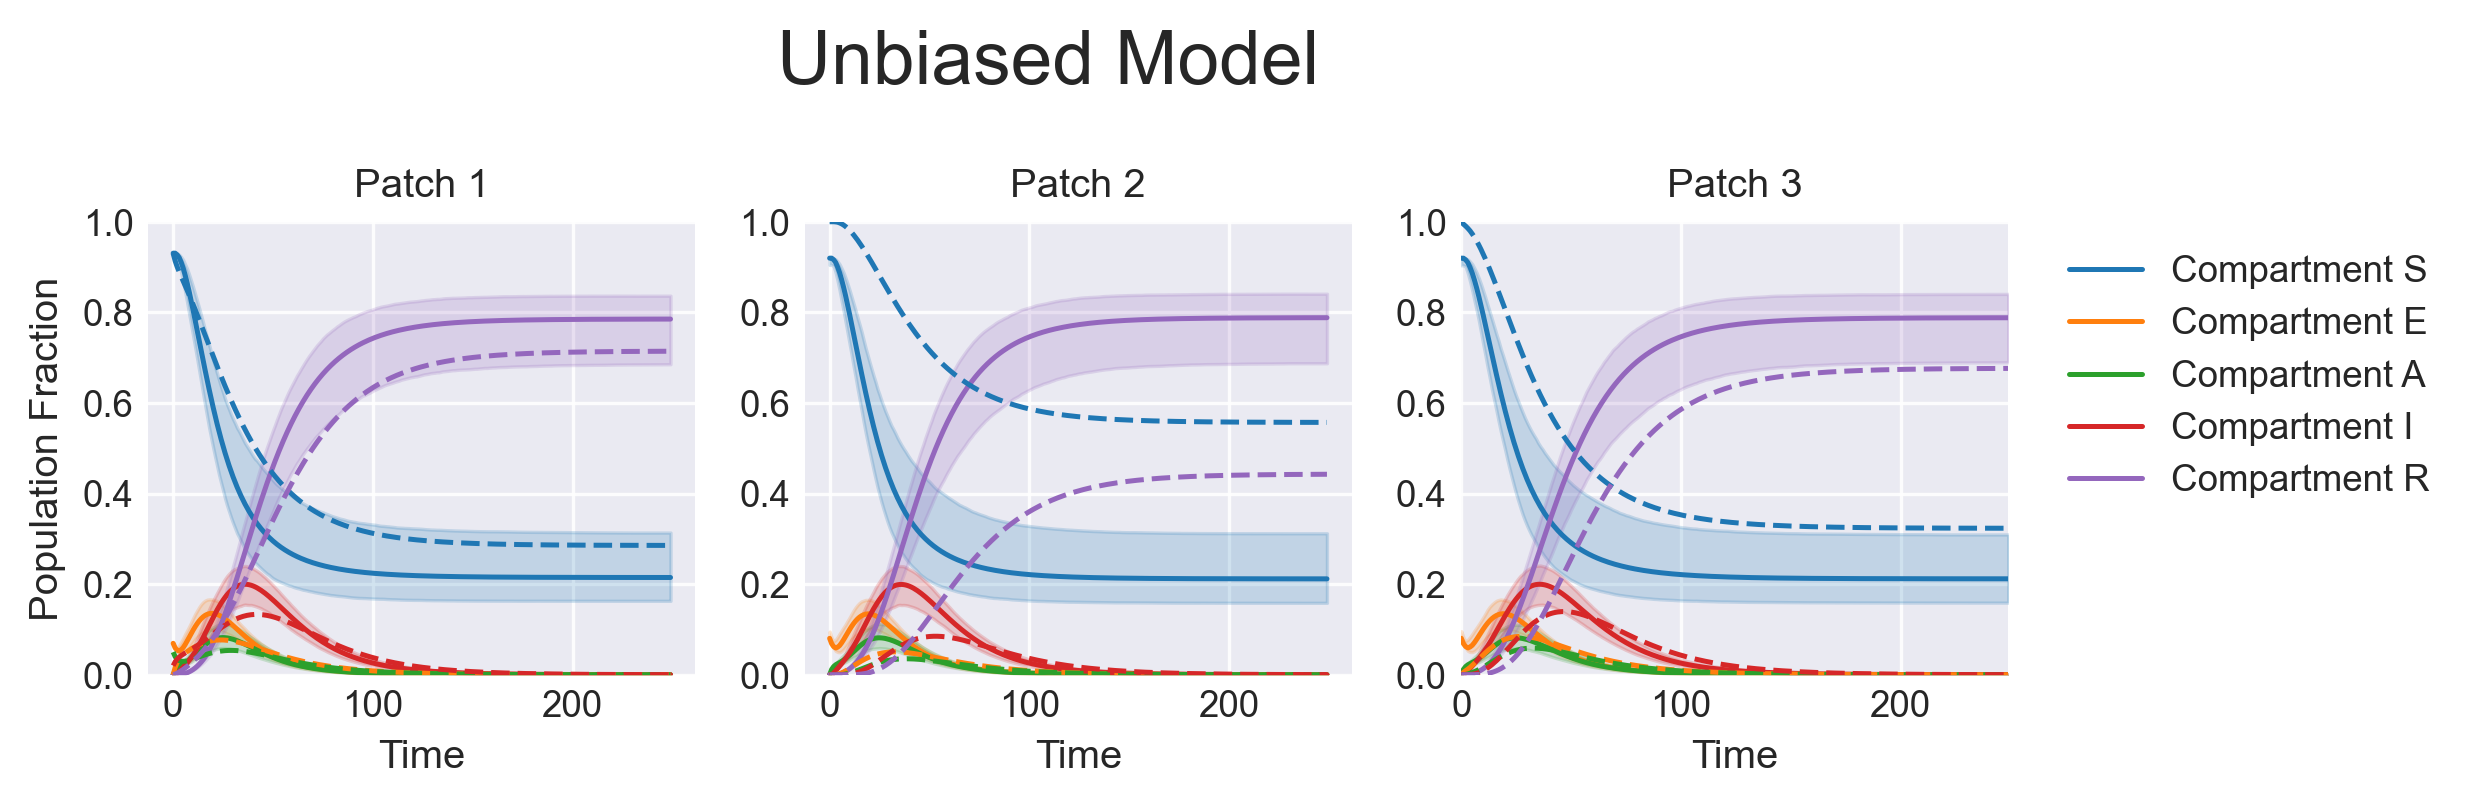

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

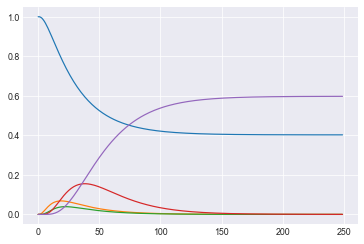

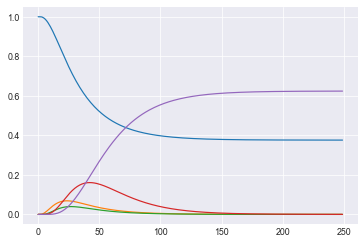

In [23]:
plt.plot(trajs[1234,:,1,:])
plt.show()
plt.plot(trajs[1234,:,2,:])
# print (trajs[:-20:,1,:] == trajs[:-20:,0,:])
# fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
# # fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
# axs[0].plot(trajs[0,:,0,:])
# axs[1].plot(trajs[100,:,1,:])
# # maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# for i in range (M):
#     plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
#     axs[i].plot(ref_traj[:,i],linestyle='--')
# axs[0].set_ylabel('Population Fraction')
# plt.show()

## Make restraints from reference trajectory

In [24]:
npoints = 5
np.random.seed(0)
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list, restraints_dict = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300838 0.10784743734654037
45 0.13207568 0.15260560737936643
31 0.121692084 0.12889426233404105
80 0.06942841 0.1421420820039372
17 0.08018887 0.11824075668734235


In [25]:
print (restraints_dict)
print (ref_traj[59,0,3])
print (ref_traj[59,0,3] - restraints[0].target)

{'npoints': 5, 'restrained_patches': [0], 'restrained_compartments': [3]}
tf.Tensor(0.11310515, shape=(), dtype=float32)
tf.Tensor(0.005257711, shape=(), dtype=float32)


## Visualizing Restraints

Text(0, 0.5, 'Population Fraction')

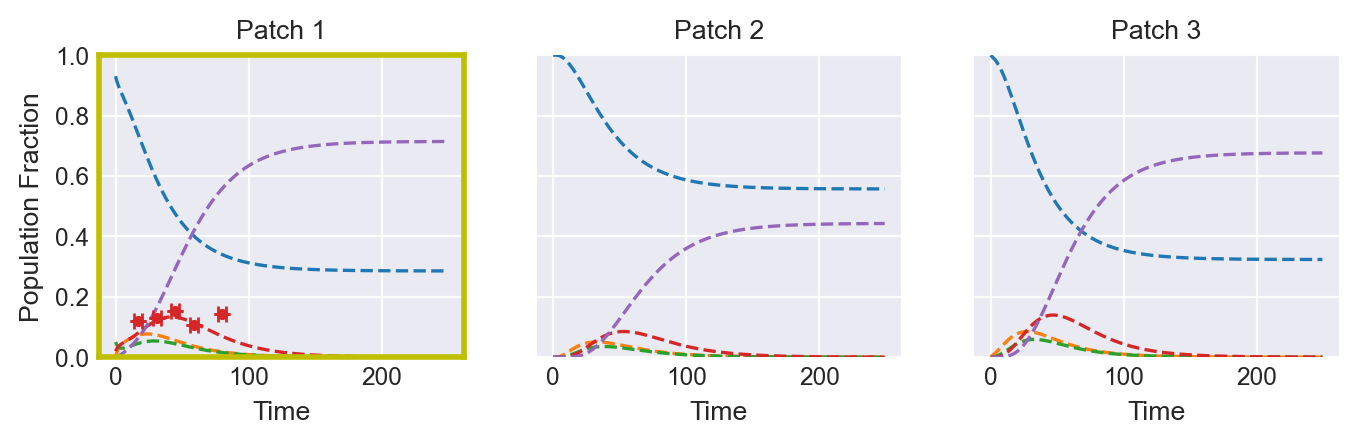

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=M, sharex=True,
                           sharey=True, figsize=(8,2), dpi =200)
for i in range(M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1),ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')


In [27]:
me_model = maxentep.MaxentModel(restraints, ref_traj=ref_traj[np.newaxis,:,:,:], trajs=trajs, population_fraction=population_fraction)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
print (ref_traj[np.newaxis,:,:,:].shape)
print (population_fraction.shape)
print (trajs.shape)

(1, 250, 3, 5)
(3,)
(8192, 250, 3, 5)


In [28]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [29]:
me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000, callbacks=[CustomCallback()])

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0023 - ref-error-metric: 1.5250 - ref-error: 1.5250 - weight-entropy: 9.0017
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0022 - ref-error-metric: 1.5168 - ref-error: 1.5168 - weight-entropy: 9.0014
Epoch 3/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0022 - ref-error-metric: 1.5209 - ref-error: 1.5209 - weight-entropy: 9.0011
Epoch 4/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0022 - ref-error-metric: 1.5242 - ref-error: 1.5242 - weight-entropy: 9.0008
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0022 - ref-error-metric: 1.5240 - ref-error: 1.5240 - weight-entropy: 9.0005
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0022 - ref-error-metric: 1.5153 - ref-error: 1.5153 - weight-entropy: 9.0002
Epoch 7/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0022 - ref-err

1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metric: 1.5321 - ref-error: 1.5321 - weight-entropy: 8.9828
Epoch 55/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - ref-error-metric: 1.5185 - ref-error: 1.5185 - weight-entropy: 8.9824
Epoch 56/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metric: 1.5188 - ref-error: 1.5188 - weight-entropy: 8.9820
Epoch 57/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0021 - ref-error-metric: 1.5287 - ref-error: 1.5287 - weight-entropy: 8.9816
Epoch 58/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metric: 1.5294 - ref-error: 1.5294 - weight-entropy: 8.9812
Epoch 59/1000
1/1 [==============================] - 0s 994us/step - loss: 0.0021 - ref-error-metric: 1.5102 - ref-error: 1.5102 - weight-entropy: 8.9808
Epoch 60/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - ref-error-metr

1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 1.5246 - ref-error: 1.5246 - weight-entropy: 8.9641
Epoch 108/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0020 - ref-error-metric: 1.5120 - ref-error: 1.5120 - weight-entropy: 8.9638
Epoch 109/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0020 - ref-error-metric: 1.5200 - ref-error: 1.5200 - weight-entropy: 8.9635
Epoch 110/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0020 - ref-error-metric: 1.5249 - ref-error: 1.5249 - weight-entropy: 8.9632
Epoch 111/1000
1/1 [==============================] - 0s 995us/step - loss: 0.0020 - ref-error-metric: 1.5120 - ref-error: 1.5120 - weight-entropy: 8.9630
Epoch 112/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error-metric: 1.5221 - ref-error: 1.5221 - weight-entropy: 8.9627
Epoch 113/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0020 - ref-error

1/1 [==============================] - 0s 996us/step - loss: 0.0020 - ref-error-metric: 1.5241 - ref-error: 1.5241 - weight-entropy: 8.9534
Epoch 161/1000
1/1 [==============================] - 0s 970us/step - loss: 0.0020 - ref-error-metric: 1.5134 - ref-error: 1.5134 - weight-entropy: 8.9533
Epoch 162/1000
1/1 [==============================] - 0s 966us/step - loss: 0.0019 - ref-error-metric: 1.5298 - ref-error: 1.5298 - weight-entropy: 8.9532
Epoch 163/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5164 - ref-error: 1.5164 - weight-entropy: 8.9531
Epoch 164/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5224 - ref-error: 1.5224 - weight-entropy: 8.9529
Epoch 165/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5313 - ref-error: 1.5313 - weight-entropy: 8.9528
Epoch 166/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-erro

1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5288 - ref-error: 1.5288 - weight-entropy: 8.9487
Epoch 214/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5198 - ref-error: 1.5198 - weight-entropy: 8.9486
Epoch 215/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5256 - ref-error: 1.5256 - weight-entropy: 8.9485
Epoch 216/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5062 - ref-error: 1.5062 - weight-entropy: 8.9485
Epoch 217/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5220 - ref-error: 1.5220 - weight-entropy: 8.9484
Epoch 218/1000
1/1 [==============================] - 0s 994us/step - loss: 0.0019 - ref-error-metric: 1.5255 - ref-error: 1.5255 - weight-entropy: 8.9483
Epoch 219/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0019 - ref-

1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 1.5139 - ref-error: 1.5139 - weight-entropy: 8.9456
Epoch 267/1000
1/1 [==============================] - 0s 991us/step - loss: 0.0019 - ref-error-metric: 1.5214 - ref-error: 1.5214 - weight-entropy: 8.9455
Epoch 268/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5313 - ref-error: 1.5313 - weight-entropy: 8.9455
Epoch 269/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 1.5300 - ref-error: 1.5300 - weight-entropy: 8.9454
Epoch 270/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0019 - ref-error-metric: 1.5192 - ref-error: 1.5192 - weight-entropy: 8.9453
Epoch 271/1000
1/1 [==============================] - 0s 965us/step - loss: 0.0019 - ref-error-metric: 1.5165 - ref-error: 1.5165 - weight-entropy: 8.9453
Epoch 272/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - re

1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5098 - ref-error: 1.5098 - weight-entropy: 8.9424
Epoch 320/1000
1/1 [==============================] - 0s 995us/step - loss: 0.0019 - ref-error-metric: 1.5650 - ref-error: 1.5650 - weight-entropy: 8.9423
Epoch 321/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0019 - ref-error-metric: 1.5287 - ref-error: 1.5287 - weight-entropy: 8.9423
Epoch 322/1000
1/1 [==============================] - 0s 995us/step - loss: 0.0019 - ref-error-metric: 1.5330 - ref-error: 1.5330 - weight-entropy: 8.9422
Epoch 323/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5240 - ref-error: 1.5240 - weight-entropy: 8.9421
Epoch 324/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0019 - ref-error-metric: 1.5268 - ref-error: 1.5268 - weight-entropy: 8.9421
Epoch 325/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-e

1/1 [==============================] - 0s 993us/step - loss: 0.0019 - ref-error-metric: 1.5014 - ref-error: 1.5014 - weight-entropy: 8.9387
Epoch 373/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0019 - ref-error-metric: 1.5227 - ref-error: 1.5227 - weight-entropy: 8.9387
Epoch 374/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0019 - ref-error-metric: 1.5256 - ref-error: 1.5256 - weight-entropy: 8.9386
Epoch 375/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5368 - ref-error: 1.5368 - weight-entropy: 8.9385
Epoch 376/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-error-metric: 1.5214 - ref-error: 1.5214 - weight-entropy: 8.9385
Epoch 377/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0019 - ref-error-metric: 1.5300 - ref-error: 1.5300 - weight-entropy: 8.9384
Epoch 378/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0019 - ref-er

1/1 [==============================] - 0s 991us/step - loss: 0.0018 - ref-error-metric: 1.5311 - ref-error: 1.5311 - weight-entropy: 8.9347
Epoch 426/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5239 - ref-error: 1.5239 - weight-entropy: 8.9346
Epoch 427/1000
1/1 [==============================] - 0s 994us/step - loss: 0.0018 - ref-error-metric: 1.5094 - ref-error: 1.5094 - weight-entropy: 8.9345
Epoch 428/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5125 - ref-error: 1.5125 - weight-entropy: 8.9345
Epoch 429/1000
1/1 [==============================] - 0s 973us/step - loss: 0.0018 - ref-error-metric: 1.5171 - ref-error: 1.5171 - weight-entropy: 8.9344
Epoch 430/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5238 - ref-error: 1.5238 - weight-entropy: 8.9343
Epoch 431/1000
1/1 [==============================] - 0s 995us/step - loss: 0.0018 - re

1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5230 - ref-error: 1.5230 - weight-entropy: 8.9303
Epoch 479/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5117 - ref-error: 1.5117 - weight-entropy: 8.9302
Epoch 480/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0018 - ref-error-metric: 1.5326 - ref-error: 1.5326 - weight-entropy: 8.9302
Epoch 481/1000
1/1 [==============================] - 0s 993us/step - loss: 0.0018 - ref-error-metric: 1.5132 - ref-error: 1.5132 - weight-entropy: 8.9301
Epoch 482/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5178 - ref-error: 1.5178 - weight-entropy: 8.9300
Epoch 483/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5141 - ref-error: 1.5141 - weight-entropy: 8.9299
Epoch 484/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-

1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5243 - ref-error: 1.5243 - weight-entropy: 8.9257
Epoch 532/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5218 - ref-error: 1.5218 - weight-entropy: 8.9257
Epoch 533/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5085 - ref-error: 1.5085 - weight-entropy: 8.9256
Epoch 534/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5303 - ref-error: 1.5303 - weight-entropy: 8.9255
Epoch 535/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5187 - ref-error: 1.5187 - weight-entropy: 8.9254
Epoch 536/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - ref-error-metric: 1.5252 - ref-error: 1.5252 - weight-entropy: 8.9253
Epoch 537/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-

1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5312 - ref-error: 1.5312 - weight-entropy: 8.9210
Epoch 585/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0018 - ref-error-metric: 1.5253 - ref-error: 1.5253 - weight-entropy: 8.9209
Epoch 586/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5224 - ref-error: 1.5224 - weight-entropy: 8.9208
Epoch 587/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5110 - ref-error: 1.5110 - weight-entropy: 8.9208
Epoch 588/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - ref-error-metric: 1.5212 - ref-error: 1.5212 - weight-entropy: 8.9207
Epoch 589/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5362 - ref-error: 1.5362 - weight-entropy: 8.9206
Epoch 590/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error

1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5325 - ref-error: 1.5325 - weight-entropy: 8.9162
Epoch 638/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5340 - ref-error: 1.5340 - weight-entropy: 8.9161
Epoch 639/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0018 - ref-error-metric: 1.5160 - ref-error: 1.5160 - weight-entropy: 8.9160
Epoch 640/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5133 - ref-error: 1.5133 - weight-entropy: 8.9160
Epoch 641/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0018 - ref-error-metric: 1.5030 - ref-error: 1.5030 - weight-entropy: 8.9159
Epoch 642/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5371 - ref-error: 1.5371 - weight-entropy: 8.9158
Epoch 643/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-erro

1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5141 - ref-error: 1.5141 - weight-entropy: 8.9114
Epoch 691/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0018 - ref-error-metric: 1.5210 - ref-error: 1.5210 - weight-entropy: 8.9113
Epoch 692/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - ref-error-metric: 1.5340 - ref-error: 1.5340 - weight-entropy: 8.9112
Epoch 693/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.4930 - ref-error: 1.4930 - weight-entropy: 8.9111
Epoch 694/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0018 - ref-error-metric: 1.5630 - ref-error: 1.5630 - weight-entropy: 8.9110
Epoch 695/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-error-metric: 1.5283 - ref-error: 1.5283 - weight-entropy: 8.9109
Epoch 696/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0018 - ref-er

1/1 [==============================] - 0s 987us/step - loss: 0.0017 - ref-error-metric: 1.5166 - ref-error: 1.5166 - weight-entropy: 8.9064
Epoch 744/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5140 - ref-error: 1.5140 - weight-entropy: 8.9063
Epoch 745/1000
1/1 [==============================] - 0s 994us/step - loss: 0.0017 - ref-error-metric: 1.5105 - ref-error: 1.5105 - weight-entropy: 8.9063
Epoch 746/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5127 - ref-error: 1.5127 - weight-entropy: 8.9062
Epoch 747/1000
1/1 [==============================] - 0s 991us/step - loss: 0.0017 - ref-error-metric: 1.5140 - ref-error: 1.5140 - weight-entropy: 8.9061
Epoch 748/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - ref-error-metric: 1.5118 - ref-error: 1.5118 - weight-entropy: 8.9060
Epoch 749/1000
1/1 [==============================] - 0s 994us/step - loss: 0.0017 - ref-err

1/1 [==============================] - 0s 970us/step - loss: 0.0017 - ref-error-metric: 1.5356 - ref-error: 1.5356 - weight-entropy: 8.9014
Epoch 797/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5187 - ref-error: 1.5187 - weight-entropy: 8.9013
Epoch 798/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - ref-error-metric: 1.5538 - ref-error: 1.5538 - weight-entropy: 8.9012
Epoch 799/1000
1/1 [==============================] - 0s 995us/step - loss: 0.0017 - ref-error-metric: 1.5212 - ref-error: 1.5212 - weight-entropy: 8.9011
Epoch 800/1000
1/1 [==============================] - 0s 0s/step - loss: 0.0017 - ref-error-metric: 1.5151 - ref-error: 1.5151 - weight-entropy: 8.9010
Epoch 801/1000
1/1 [==============================] - 0s 1000us/step - loss: 0.0017 - ref-error-metric: 1.5529 - ref-error: 1.5529 - weight-entropy: 8.9010
Epoch 802/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error

1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5079 - ref-error: 1.5079 - weight-entropy: 8.8963
Epoch 850/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5378 - ref-error: 1.5378 - weight-entropy: 8.8962
Epoch 851/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0017 - ref-error-metric: 1.5101 - ref-error: 1.5101 - weight-entropy: 8.8961
Epoch 852/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5195 - ref-error: 1.5195 - weight-entropy: 8.8960
Epoch 853/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5321 - ref-error: 1.5321 - weight-entropy: 8.8959
Epoch 854/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5208 - ref-error: 1.5208 - weight-entropy: 8.8958
Epoch 855/1000
1/1 [==============================] - 0s 973us/step - loss: 0.0017 - ref-error-

1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5294 - ref-error: 1.5294 - weight-entropy: 8.8910
Epoch 903/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5148 - ref-error: 1.5148 - weight-entropy: 8.8909
Epoch 904/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0017 - ref-error-metric: 1.4993 - ref-error: 1.4993 - weight-entropy: 8.8908
Epoch 905/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-metric: 1.5309 - ref-error: 1.5309 - weight-entropy: 8.8907
Epoch 906/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-error-metric: 1.5221 - ref-error: 1.5221 - weight-entropy: 8.8906
Epoch 907/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0017 - ref-error-metric: 1.5339 - ref-error: 1.5339 - weight-entropy: 8.8905
Epoch 908/1000
1/1 [==============================] - 0s 993us/step - loss: 0.0017 - ref-

1/1 [==============================] - 0s 994us/step - loss: 0.0017 - ref-error-metric: 1.5277 - ref-error: 1.5277 - weight-entropy: 8.8854
Epoch 956/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5272 - ref-error: 1.5272 - weight-entropy: 8.8853
Epoch 957/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5196 - ref-error: 1.5196 - weight-entropy: 8.8852
Epoch 958/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5266 - ref-error: 1.5266 - weight-entropy: 8.8851
Epoch 959/1000
1/1 [==============================] - 0s 996us/step - loss: 0.0017 - ref-error-metric: 1.5254 - ref-error: 1.5254 - weight-entropy: 8.8850
Epoch 960/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0017 - ref-error-metric: 1.5322 - ref-error: 1.5322 - weight-entropy: 8.8849
Epoch 961/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0017 - ref-erro

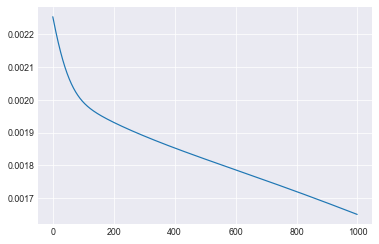

In [30]:
plt.plot(me_history.history['loss'])

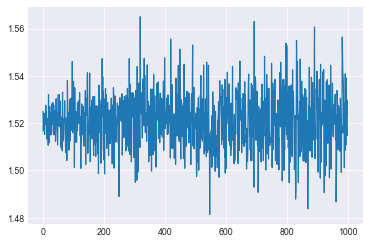

In [31]:
plt.plot(me_history.history['ref-error'])

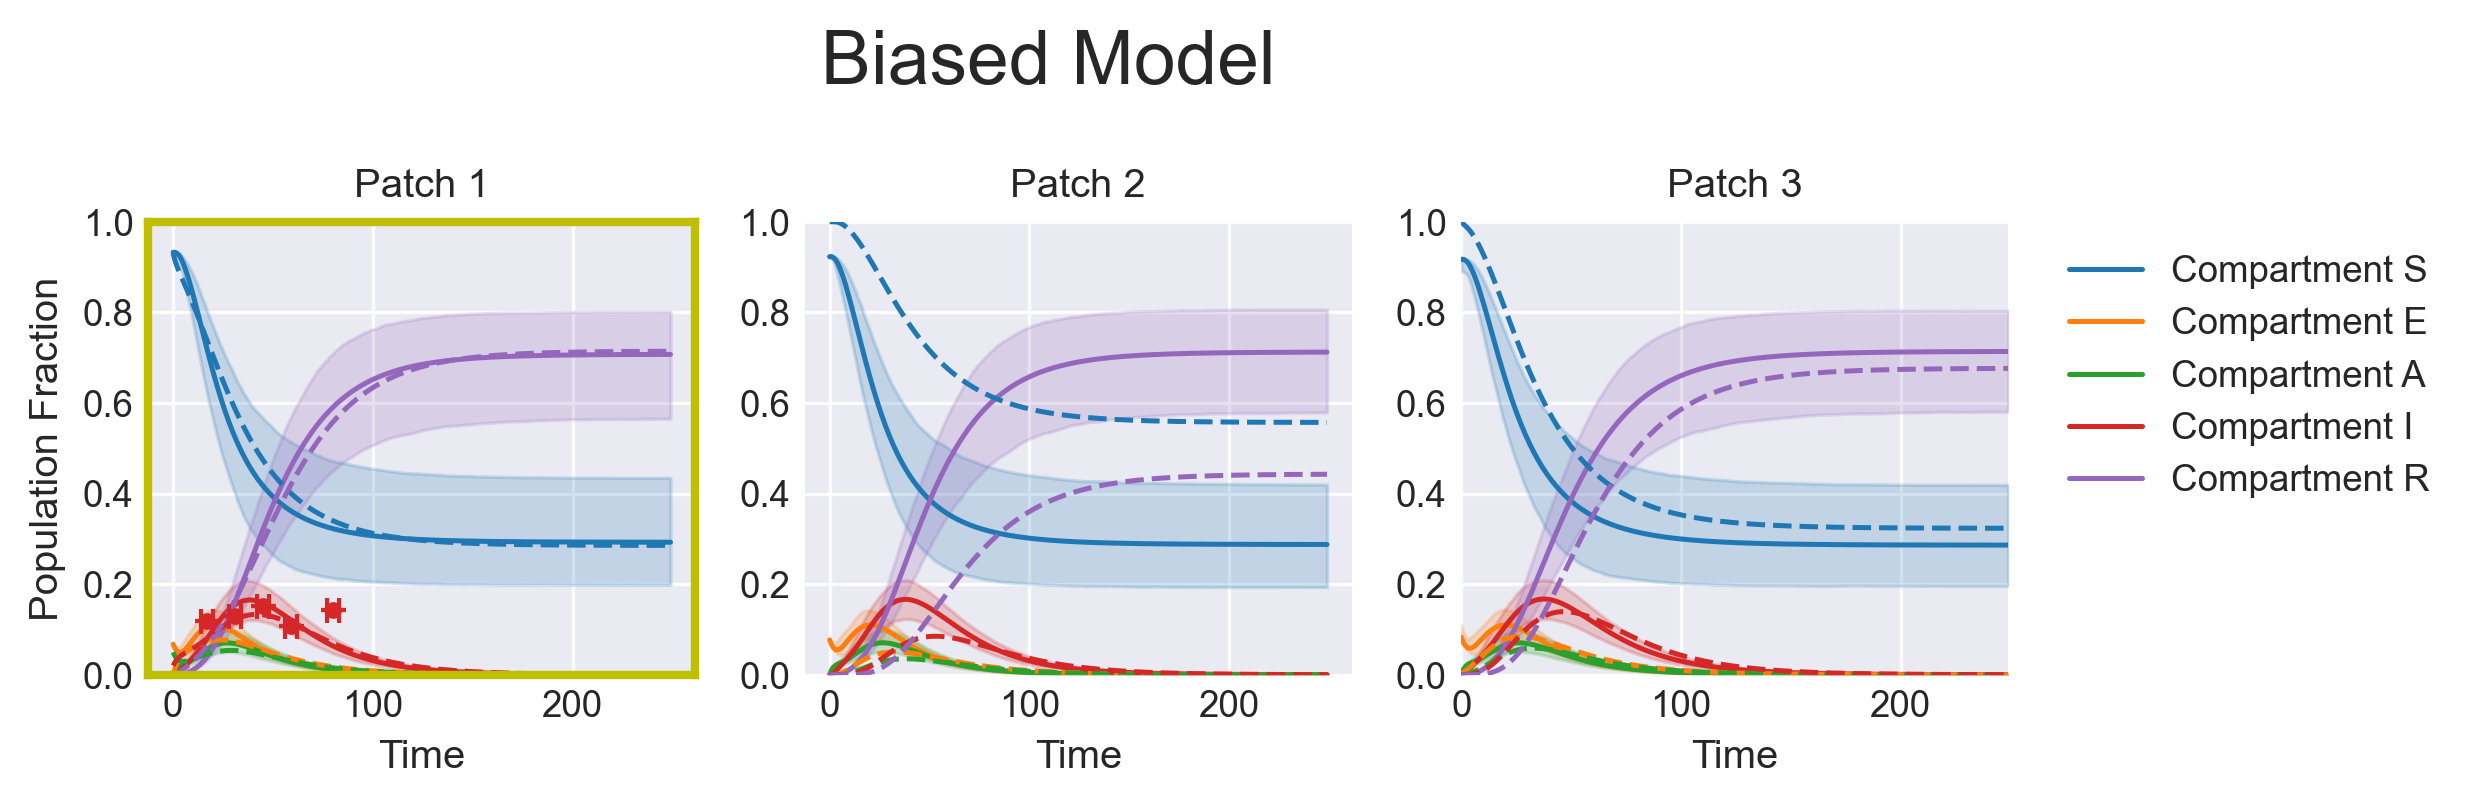

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(me_model.trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,1,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,2,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [33]:
Tmtat = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.05
# start[1,0] = 0.05
beta_start = 0.1
infect = maxentep.ContactInfectionLayer(beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, agreement)

In [34]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(timesteps)
regressed_traj = rmodel.get_traj()

250/250 [==============================] - 41s 163ms/step - loss: 0.0032 - output_2_loss: 0.0032


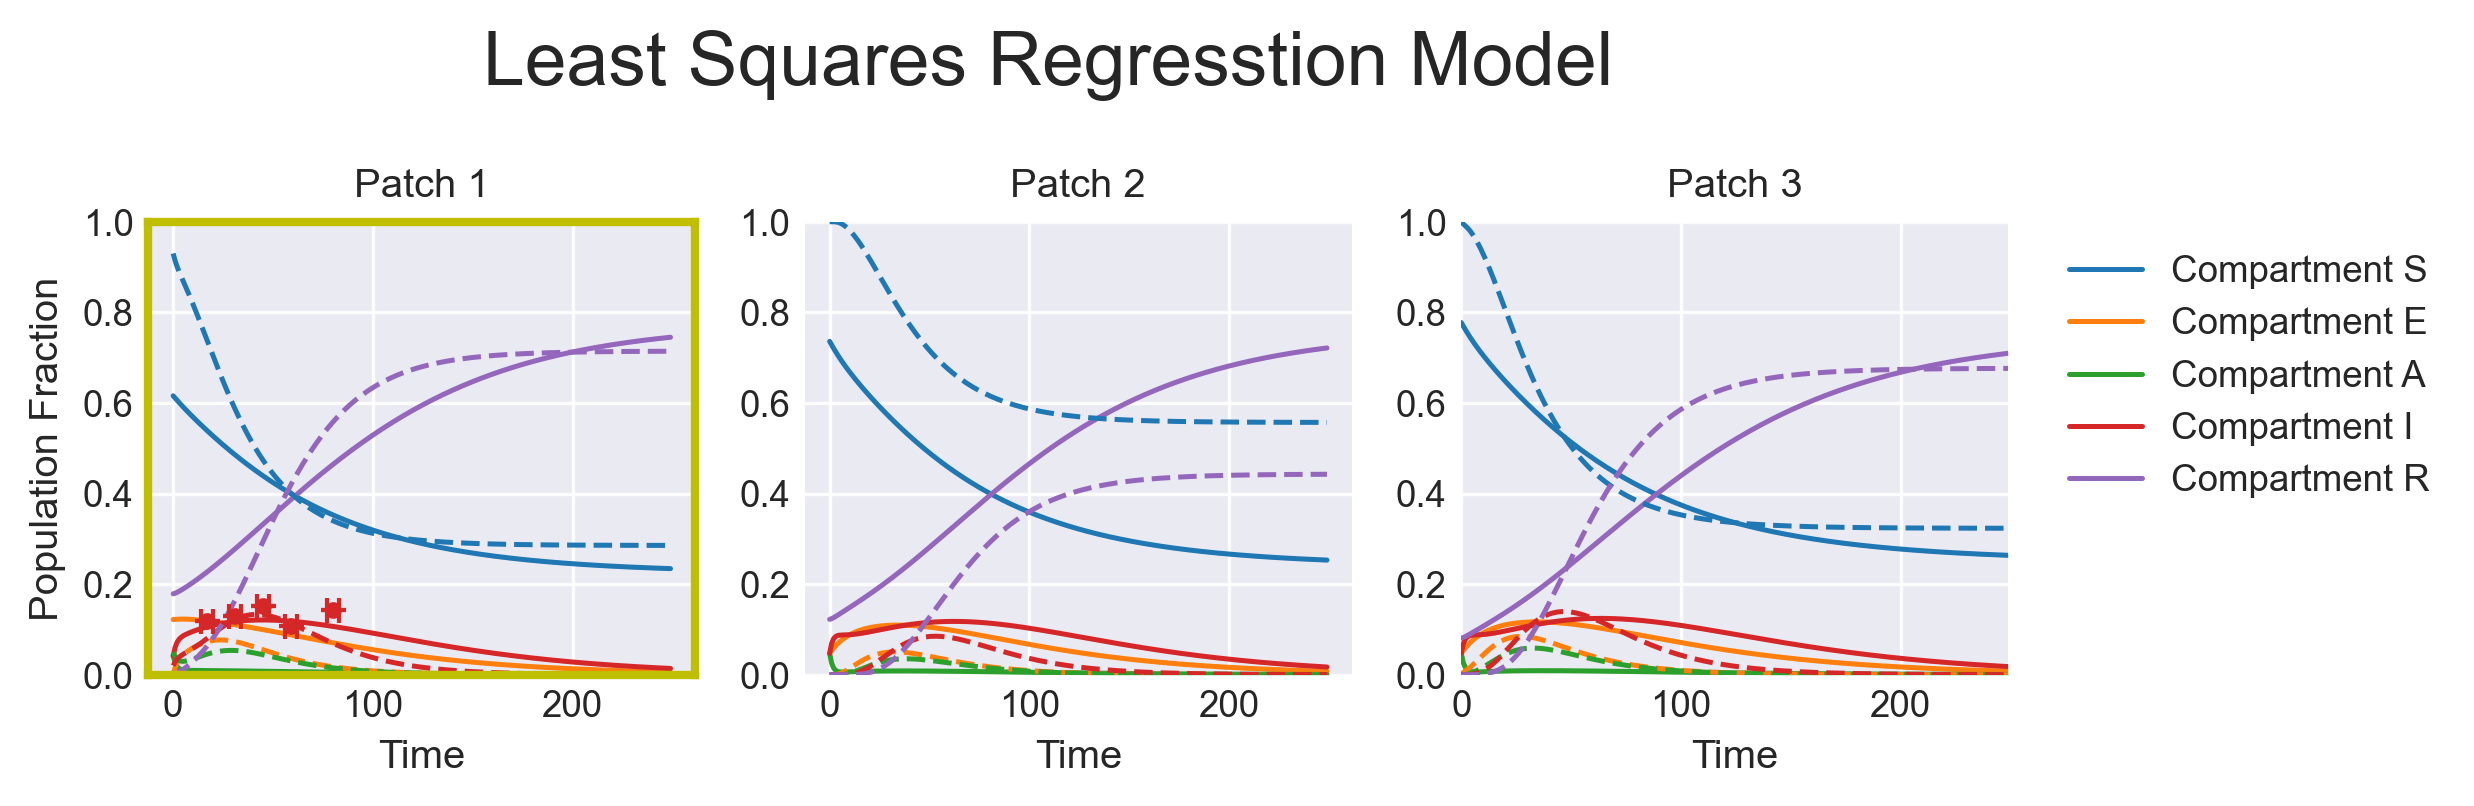

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regresstion Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
#     axs[i].plot(regressed_traj[0,:,i,:])
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Hyper-biasing

In [36]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R_norm , tmat, name='unbiased_model', hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.SGD(1))
# fit_param_model.compile(tf.optimizers.Adam(0.1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')

In [37]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)

Epoch 1/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1589
Epoch 2/1000
128/128 [==============================] - ETA: 0s - loss: 0.0026 - weight-entropy: 4.15 - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1589
Epoch 3/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1589
Epoch 4/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1589
Epoch 5/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1589
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1589
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1589
Epoch 8/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 4.1589
Epoch 9/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0026 - wei

128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1581
Epoch 70/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1580
Epoch 71/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1580
Epoch 72/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1580
Epoch 73/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1580
Epoch 74/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1580
Epoch 75/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 4.1579
Epoch 76/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1579
Epoch 77/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 4.1579
Epoch 78/1000
128/128 [==========

128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1557
Epoch 144/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1557
Epoch 145/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 4.1556
Epoch 146/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1556
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1555
Epoch 148/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1555
Epoch 149/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1554
Epoch 150/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1554
Epoch 151/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 4.1554
Epoch 152/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1522
Epoch 218/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1522
Epoch 219/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1521
Epoch 220/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1521
Epoch 221/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 4.1520
Epoch 222/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1520
Epoch 223/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1519
Epoch 224/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1519
Epoch 225/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1518
Epoch 226/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1481
Epoch 292/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1480
Epoch 293/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1479
Epoch 294/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1479
Epoch 295/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1478
Epoch 296/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1478
Epoch 297/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1477
Epoch 298/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1477
Epoch 299/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1476
Epoch 300/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1435
Epoch 366/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1434
Epoch 367/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1433
Epoch 368/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1433
Epoch 369/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1433
Epoch 370/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1432
Epoch 371/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1431
Epoch 372/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1430
Epoch 373/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1430
Epoch 374/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1388
Epoch 440/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1387
Epoch 441/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1387
Epoch 442/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1387
Epoch 443/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1386
Epoch 444/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1385
Epoch 445/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1384
Epoch 446/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1383
Epoch 447/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1383
Epoch 448/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1341
Epoch 514/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1340
Epoch 515/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1339
Epoch 516/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1340
Epoch 517/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1339
Epoch 518/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 4.1338
Epoch 519/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1337
Epoch 520/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.1337
Epoch 521/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1336
Epoch 522/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1296
Epoch 588/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1294
Epoch 589/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1294
Epoch 590/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1293
Epoch 591/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1292
Epoch 592/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1291
Epoch 593/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1292
Epoch 594/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1291
Epoch 595/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1291
Epoch 596/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1255
Epoch 662/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1252
Epoch 663/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1250
Epoch 664/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1250
Epoch 665/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1249
Epoch 666/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1248
Epoch 667/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1247
Epoch 668/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1247
Epoch 669/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1247
Epoch 670/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1212
Epoch 736/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1210
Epoch 737/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1212
Epoch 738/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1209
Epoch 739/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1209
Epoch 740/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1208
Epoch 741/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1208
Epoch 742/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1207
Epoch 743/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1206
Epoch 744/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1172
Epoch 809/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1172
Epoch 810/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1173
Epoch 811/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1172
Epoch 812/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1172
Epoch 813/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1171
Epoch 814/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1173
Epoch 815/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1170
Epoch 816/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1170
Epoch 817/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1139
Epoch 883/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1138
Epoch 884/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1138
Epoch 885/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1137
Epoch 886/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1137
Epoch 887/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1137
Epoch 888/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1136
Epoch 889/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1136
Epoch 890/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1133
Epoch 891/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1107
Epoch 957/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1105
Epoch 958/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1106
Epoch 959/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 4.1107
Epoch 960/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1104
Epoch 961/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1104
Epoch 962/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1103
Epoch 963/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1105
Epoch 964/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1108
Epoch 965/1000
128/128 [=

In [38]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)

Epoch 1/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 4.1464
Epoch 2/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 4.1111
Epoch 3/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.0904
Epoch 4/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 4.0847
Epoch 5/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.0810
Epoch 6/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.0709
Epoch 7/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.0672
Epoch 8/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 4.0631
Epoch 9/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0554
Epoch 10/200
128/128 [===============

128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.5719
Epoch 71/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5691
Epoch 72/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.5601
Epoch 73/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.5678
Epoch 74/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5666
Epoch 75/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.5598
Epoch 76/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5544
Epoch 77/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.5461
Epoch 78/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.5423
Epoch 79/200
128/128 [===================

128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4386
Epoch 146/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4383
Epoch 147/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4355
Epoch 148/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4367
Epoch 149/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4346
Epoch 150/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 3.4400
Epoch 151/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4275
Epoch 152/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 3.4284
Epoch 153/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 3.4274
Epoch 154/200
128/128 [==========

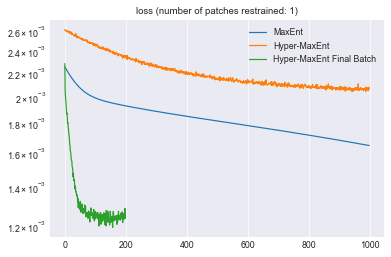

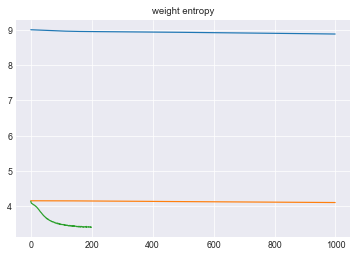

In [39]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
# plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

# plt.plot(hme_history.history['prior-loss'])
# plt.title('neg log-likelihood')
# plt.show()

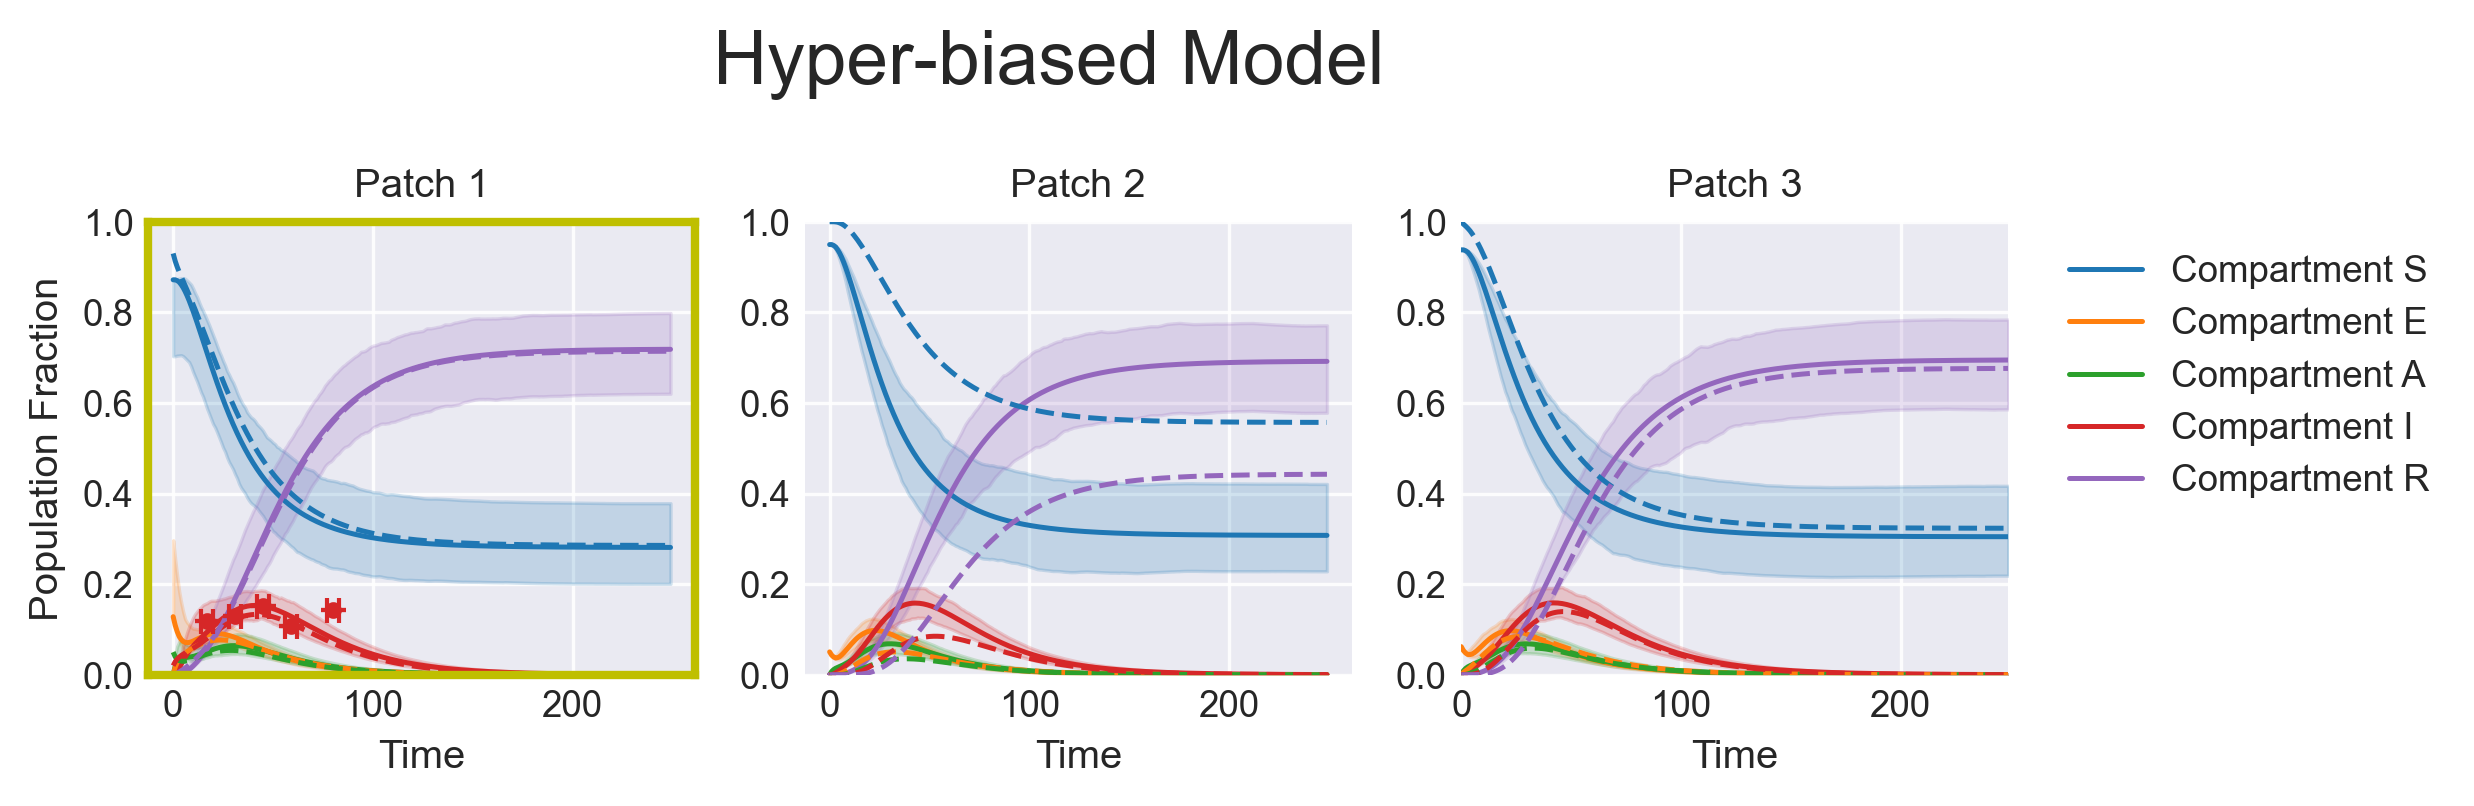

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Hyper-biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## ABC

In [34]:
import pyabc
import os
beta = 0.025
E_time = 7
A_time = 5
I_time = 14
def sbi_model(parameters):
    start, beta, E_time, A_time, I_time = parameters['start'], \
                                                   + float(parameters['beta']), float(parameters['E_time']), \
                                                   + float(parameters['A_time']), float(parameters['I_time'])
    compartments = ['E', 'A', 'I', 'R']
    infections_compartments = [1,2]
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 3)
    tmat.add_transition('A', 'I', A_time, 3)
    tmat.add_transition('I', 'R', I_time, 4)
    infect_fxn_sbi = maxentep.contact_infection_func(infections_compartments)
    timesteps = 250
    meta_model = maxentep.MetaModel(infect_fxn_sbi, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    restrainted_time_values = [59, 45, 31, 80, 17]
    values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return {'data': values}
sbi_param_keys = [ 'start', 'beta', 'E_time', 'A_time', 'I_time' ]
sbi_param_values = [start, beta, E_time, A_time, I_time ] 
sbi_parameters = dict(zip(sbi_param_keys, sbi_param_values))
sbi_result = sbi_model(sbi_parameters)


def distance(x, y):
    print ('current calue', x['data'])
    print ('goal', y['data'])
    d = np.sum(np.abs(x['data'] - y['data']))
    print (f'distance{d}')
    return(d)

# 59 0.11300838 0.10784743734654037
# 45 0.13207568 0.15260560737936643
# 31 0.121692084 0.12889426233404105
# 80 0.06942841 0.1421420820039372
# 17 0.08018887 0.11824075668734235
print (sbi_result)

# R_norm, start, beta, E_time, A_time, I_time 
parameter_priors = pyabc.Distribution(# R_norm=pyabc.RV("norm", sbi_param_values[0], 1), 
                                start=pyabc.RV("norm", sbi_param_values[0], 0.01),
                                beta=pyabc.RV("norm", sbi_param_values[1], 0.1),
                                E_time=pyabc.RV("norm", sbi_param_values[2], 1),
                                A_time=pyabc.RV("norm", sbi_param_values[3], 1),
                                I_time=pyabc.RV("norm", sbi_param_values[4], 1))

print(parameter_priors )



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



{'data': array([0.12532003, 0.14010824, 0.11538681, 0.07863417, 0.05513906],
      dtype=float32)}
<Distribution 'A_time', 'E_time', 'I_time', 'beta', 'start'>


In [38]:
abc = pyabc.ABCSMC(sbi_model, parameter_priors, distance)
db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_gravitation.db') 
observation = np.array([r.target for r in restraints])
abc.new(db_path, {'data': observation})
# x_1 = np.array([0.009231301, 0.028030522, 0.08351496, 0.0017322148, 0.22831888])
# x_2 = np.array([0.10784743734654037, 0.15260560737936643, 0.12889426233404105, 0.1421420820039372, 0.11824075668734235])
# print(distance(x_1,x_2))
print (observation)

KeyboardInterrupt: 

In [37]:
import logging
tf.get_logger().setLevel(logging.ERROR)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:Epsilon:initial epsilon is 0.5832638263910389
INFO:ABC:t: 1, eps: 0.5832638263910389.


current calue [0.00052758 0.00133865 0.00338009 0.00013044 0.00810375]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6362496366874163
current calue [0.00050768 0.00146227 0.00403363 0.00010156 0.00952717]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6340978408571297
current calue [0.13757348 0.2084921  0.22690307 0.05655853 0.11624991]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.2711957325252106
current calue [1.9362046e-04 5.8679900e-04 1.7710148e-03 3.6680474e-05 5.0493437e-03]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.642092687363465
current calue [0.13032937 0.25416207 0.34148774 0.03641859 0.18586804]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.509982650158388
current calue [0.09943781 0.22391567 0.40117368 0.02643587 0.3281317 ]
goal [0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]
distance0.6775962646769559
current calue [0.000715   0

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
plt.rc('axes', titlesize=8)

import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), dpi =300)

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'Unbiased Trajectory in Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(0.6,0.5), fontsize=6)


plt.setp(axs[1], xlabel='Time', title = 'Biased Trajectories for Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_hyperbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_hyperbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_hyperbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[1, :, :] = mtrajs_hyperbiased
print(qtrajs_hyperbiased.shape)
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= 'C4',  label='MaxEnt hyper-biased model')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='C4', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= 'C2',  label='Least squares biased model')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Reference model')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
plt.savefig('neurips.png', transparent=False, dpi = 300)


In [ ]:
print (restraints)
print(hme_model.trajs.shape)

In [ ]:
LS_sample_trajs = np.empty((npoints,trajs.shape[1],trajs.shape[2],trajs.shape[-1]))
HyperMaxEnt_sample_trajs = np.empty_like(LS_sample_trajs)
for i in range(npoints):
    sampled_restraints = [n for n in restraints if n != restraints[i]]
    def new_agreement(traj, rs=sampled_restraints):
        s = 0
        for r in rs:
            s += r(traj[0])**2
        return s
    rmodel_sampled = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, new_agreement)
    rmodel_sampled.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
    utraj_sampled = rmodel_sampled.get_traj()
    rmodel_sampled.fit(timesteps)
    regressed_traj_sampled = rmodel_sampled.get_traj()
    LS_sample_trajs[i,:,:,:] = regressed_traj_sampled
    
    hme_model_sample = maxentep.HyperMaxentModel(sampled_restraints, fit_param_model, model, reweight=False)
    hme_model_sample.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')
    hme_history_sample = hme_model_sample.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)
    hme_model_sample.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
    # hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
    hme_final_history_sample = hme_model_sample.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)
    HyperMaxEnt_sample_trajs[i,:,:,:] = np.sum(hme_model_sample.trajs * hme_model_sample.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)

In [ ]:
np.save('HyperMaxEnt_sample_trajs',HyperMaxEnt_sample_trajs)
np.save('LS_sample_trajs',LS_sample_trajs)

NameError: name 'HyperMaxEnt_sample_trajs' is not defined

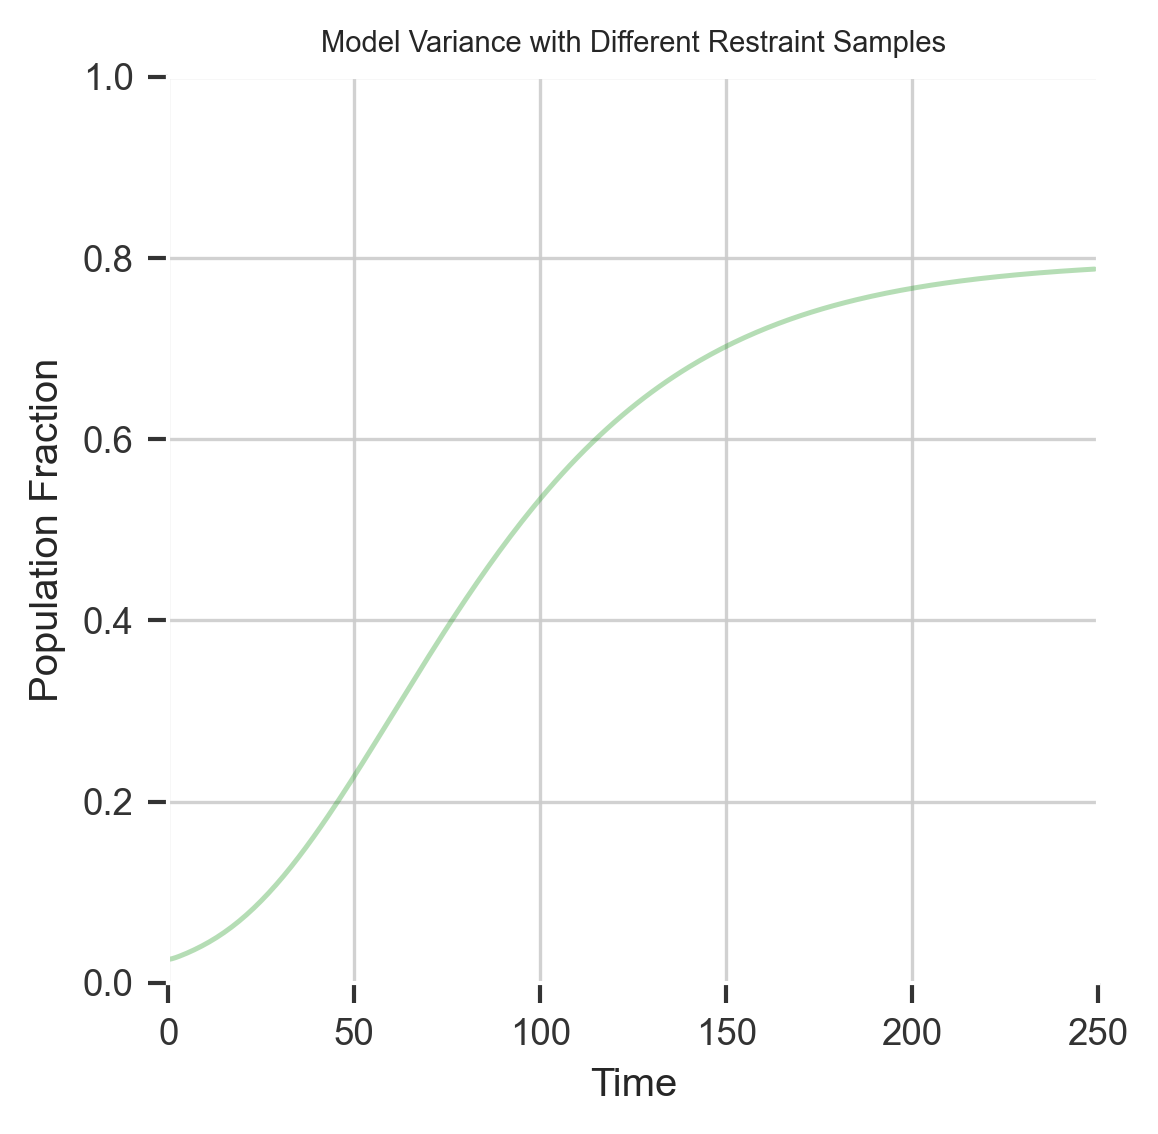

In [42]:
HperMaxEnt_sample_trajs = np.load('HyperMaxEnt_sample_trajs.npy')
LS_sample_trajs = np.load('LS_sample_trajs.npy')
fig, ax = plt.subplots(figsize=(4,4), dpi=300) 
plt.rc('axes', titlesize=7)
plt.setp(plt.gca(), ylabel='Population Fraction' ,xlabel='Time', title = "Model Variance with Different Restraint Samples", xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for i,y in enumerate(LS_sample_trajs):
    plt.plot(x, y[:,2,4], color= 'C2', alpha=0.35)
    plt.plot(x, HyperMaxEnt_sample_trajs[i,:,2,4], color= 'C4', alpha=0.35)
plt.plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='Ground Truth')
plt.legend(bbox_to_anchor=(0.65,0.45), fontsize=6)
hand, labl = ax.get_legend_handles_labels()
predicted_label_LS = 'Least Squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='C2')
predicted_label_HM = 'Maxent'
predicted_line_HM = plt.Line2D((0,1),(0,0), color='C4')
plt.legend([predicted_line_LS, predicted_line_HM]+[handle for i,handle in enumerate(hand)],
              [predicted_label_LS, predicted_label_HM]+[label for i,label in enumerate(labl)]
                , bbox_to_anchor=(0.85,0.35), fontsize=6)
plt.savefig('neurips_LS.png', transparent=False, dpi = 300)

print(np.mean(np.var(HyperMaxEnt_sample_trajs[:,:,2,4], axis=0)))
print(np.mean(np.var(LS_sample_trajs[:,:,2,4], axis=0)))


(250, 3, 5)


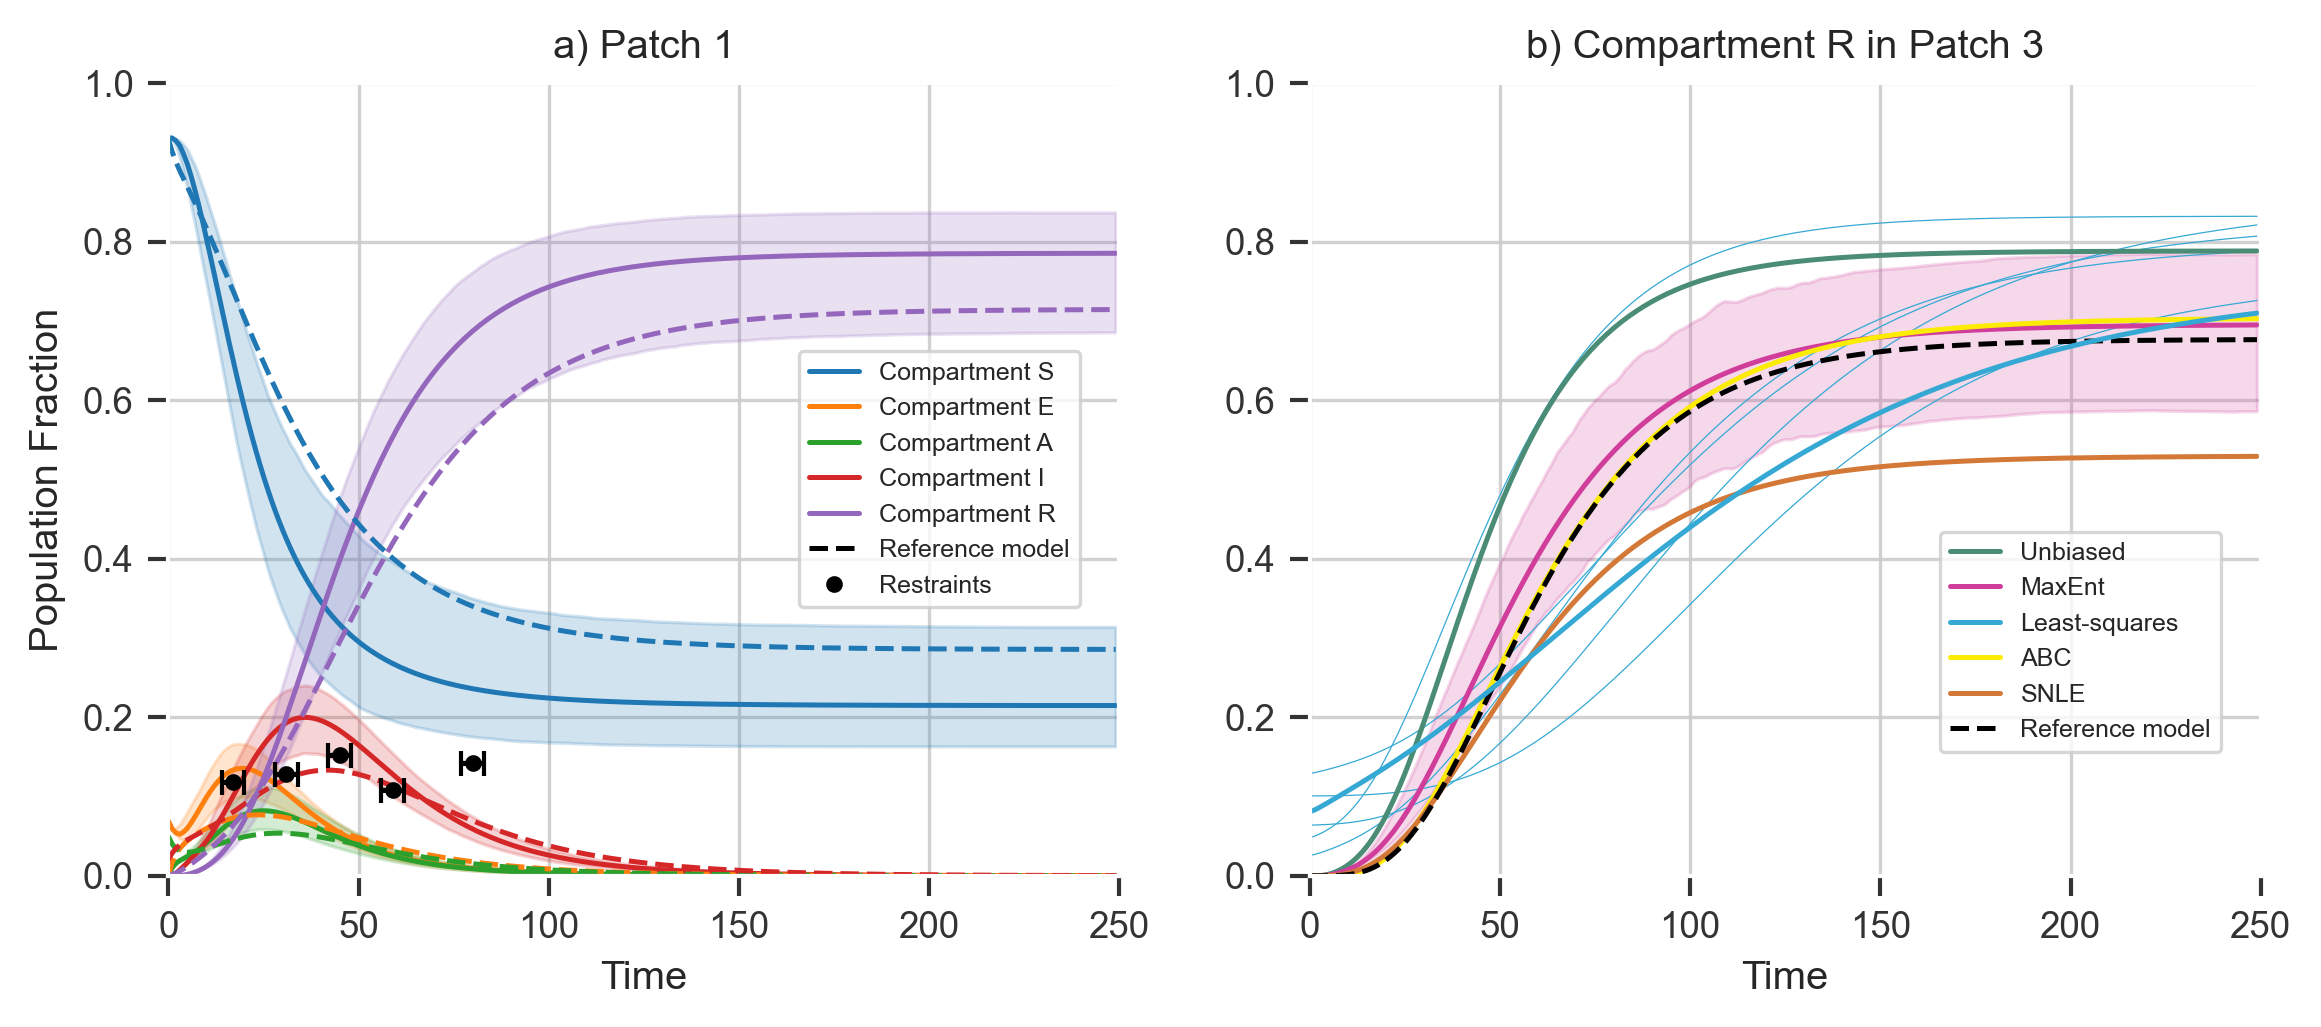

In [69]:
plt.rc('axes', titlesize=7)
abc_trajs = np.load('mean_abc_traj.npy')
sbi_trajs = np.load('mean_sbi_traj.npy')

import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']


import matplotlib.markers as mmark
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.9
plt.rcParams['grid.color'] = "#cccccc"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,3.5), dpi =300)

# fig.suptitle('Comparing Methods Performance', y = 1.0, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= True, alpha = 0.2)
axs[0].plot(ref_traj[:,0],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.setp(axs[0], xlabel='Time', title = 'a) Patch 1', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(0)]):
                pf(axs[0],0, color='black')
Reference_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
rs_marker = plt.Line2D((0,1),(0,0), color='k', marker='o',linestyle='', ms=3)
hand, labl = axs[0].get_legend_handles_labels()
Reference_label = 'Reference model'
Restraints_label = 'Restraints'
axs[0].legend([handle for i,handle in enumerate(hand)]+[Reference_line,rs_marker],
              [label for i,label in enumerate(labl)]+[Reference_label,Restraints_label]
                , bbox_to_anchor=(0.65,0.5), fontsize=6, frameon=True, fancybox=True, facecolor='white')


plt.setp(axs[1], xlabel='Time', title = 'b) Compartment R in Patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
mtrajs_biased = np.sum(me_model.trajs * me_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
w = np.ones(trajs.shape[0])
w /=np.sum(w)
mtrajs_unbiased = np.sum(trajs * w[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_hyperbiased = np.sum(hme_model.trajs * hme_model.traj_weights[:, np.newaxis, np.newaxis, np.newaxis], axis=0)
mtrajs_regressedbiased = np.sum(regressed_traj, axis=0)
x = range(trajs.shape[1])
# axs[1].plot(x, mtrajs_biased[:,2,4], color= 'C0', label='MaxEnt biased model')
qtrajs_hyperbiased = np.apply_along_axis(lambda x: maxentep.weighted_quantile(
    x, [1/3, 1/2, 2/3], sample_weight=hme_model.traj_weights), 0, hme_model.trajs)
qtrajs_hyperbiased[0, :, :] = np.clip(
            qtrajs_hyperbiased[0, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[2, :, :] = np.clip(
            qtrajs_hyperbiased[2, :, :] - qtrajs_hyperbiased[1, :, :] + mtrajs_hyperbiased, 0, 1)
qtrajs_hyperbiased[1, :, :] = mtrajs_hyperbiased
print(mtrajs_unbiased.shape)
for i,y in enumerate(LS_sample_trajs):
    axs[1].plot(y[:,2,4], color= '#35a9d4', linewidth=0.3)
axs[1].plot(x, mtrajs_unbiased[:,2,4], color= '#4a8c76',  label='Unbiased')
axs[1].plot(x, mtrajs_hyperbiased[:,2,4], color= '#D03D9A',  label='MaxEnt')
axs[1].plot(x, abc_trajs[:,2,4], color= '#fcec03')
axs[1].plot(x, sbi_trajs[:,2,4], color= '#d47837')
axs[1].plot(ref_traj[:,2,4],linestyle='--', color= 'k')
axs[1].fill_between(x, qtrajs_hyperbiased[0, :, 2, 4],qtrajs_hyperbiased[-1, :, 2, 4],
                        color='#D03D9A', alpha=0.2)
axs[1].plot(x, mtrajs_regressedbiased[:,2,4], color= '#35a9d4')
axs[1].legend(bbox_to_anchor=(0.45,0.38), fontsize=6)
hand, labl = axs[1].get_legend_handles_labels()
predicted_label_LS = 'Least-squares'
predicted_line_LS = plt.Line2D((0,1),(0,0), color='#35a9d4')
predicted_label_abc = 'ABC'
predicted_line_abc = plt.Line2D((0,1),(0,0), color='#fcec03')
predicted_label_sbi = 'SNLE'
predicted_line_sbi = plt.Line2D((0,1),(0,0), color='#d47837')
ref_label = 'Reference model'
ref_line = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
axs[1].legend([handle for i,handle in enumerate(hand)] + [predicted_line_LS, predicted_line_abc, predicted_line_sbi, ref_line] ,
              [label for i,label in enumerate(labl)] + [predicted_label_LS, predicted_label_abc, predicted_label_sbi, ref_label ]
                , bbox_to_anchor=(0.65,0.45), fontsize=6, frameon=True, fancybox=True, facecolor='white')


plt.savefig('Figure_3.png', transparent=False, dpi = 300)
